In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from ipywidgets.widgets import interact
import os
from tensorflow import keras
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score, f1_score
import tensorflow as tf

2023-01-17 21:17:32.824539: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-17 21:17:33.083347: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-17 21:17:33.083369: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-17 21:17:33.960963: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [322]:
class Ut8channels:
    '''
    Class that read unstructured bytes sequence and outputs them in a structured way.
    ''' 
    SENSORS_NUMBER = 8  
    HEADER_BYTES = 4
    SENSOR_BYTES = 1
    CTP_BYTES = 3
    ENCODER_BYTES = 3
    DATA_BYTES = 1017 # for 1 kB A-scan length
    # DATA_BYTES = 2041 # for 2 kB A-scan length
    MAX_BYTE_VALUE = 0xFF
    MIN_BYTE_VALUE = 0x00

    def __init__(self, filename):
            self.filename = filename
            self._data = self.read_utd()

    def read_utd(self):
        '''
        This function reads the ut raw file and returns a list of lists with a-scans.

        '''
        data = [[] for _ in range(Ut8channels.SENSORS_NUMBER)]
        raw_data = open(self.filename, 'rb')
        while True:  
            header_bytes = raw_data.read(Ut8channels.HEADER_BYTES)
            sensor_bytes = raw_data.read(Ut8channels.SENSOR_BYTES)
            ctp_bytes = raw_data.read(Ut8channels.CTP_BYTES) 
            encoder_bytes = raw_data.read(Ut8channels.ENCODER_BYTES)
            data_bytes = raw_data.read(Ut8channels.DATA_BYTES)
            data_array = np.frombuffer(data_bytes, dtype = np.uint8) # Interpret a buffer (bytes) as a 1-dimensional array
            output_array = (2*((data_array - Ut8channels.MIN_BYTE_VALUE)/
                (Ut8channels.MAX_BYTE_VALUE - Ut8channels.MIN_BYTE_VALUE))-1).round(2)# Data normalization [-1, 1]
            try:
                data[ord(sensor_bytes)].append(output_array) # Get the number that represents the sensor
            except:
                break

        # fill missing values with array of zeros so all sensors have the same number of ascans
        max_length = max([len(sensor) for sensor in data]) 
        fill = [np.zeros(Ut8channels.DATA_BYTES)] * max_length
        data = [sensor[:max_length] + fill[len(sensor):] for sensor in data] 

        df = pd.DataFrame(data).transpose()
        df.columns = list(range(1, Ut8channels.SENSORS_NUMBER+1)) # 1 to 8
        # df = df.fillna(value=0) doesn't fill with np array --'
        return df

    @property
    def data(self):
        return self._data

    def find_relevant_peaks(self, ascan, distance=50, prominence=0.2):
        peaks, _ = scipy.signal.find_peaks(ascan, distance=distance, prominence=prominence)
        return peaks

    def plot_ascan(self, sensor, index, show_peaks=False, show_prediction=False, model='model.h5'):
        plt.figure(figsize=(6,4), dpi=150)
        ascan = self.data[sensor][index]
        plt.ylim(-1.2, 1.2)
        color = None if any(ascan) else 'red' # if ascan was filled with zeros to equalize numbers of ascans, than it is red
        plt.plot(ascan, color=color)
        if show_peaks:
            peaks = self.find_relevant_peaks(ascan)
            plt.scatter(peaks, ascan[peaks], marker="x", color='orange')   
        if show_prediction:
            prediction = self.predict_single_ascan(model=model, ascan=ascan) # np.int64
            predicted_class = Ut8channelsTrainer.DEFECTS[prediction]
            plt.text(x=600, y=-1, s=f'Prediction: {predicted_class}', color='r', fontsize=10)  
    

    def plot_interactive_ascan(self):
        @interact(sensor=(1, Ut8channels.SENSORS_NUMBER), index=(0, len(self.data)-1), show_peaks=(0,1), show_prediction=(0,1))
        def _plot_interactive_ascan(sensor, index, show_peaks, show_prediction):
            self.plot_ascan(sensor=sensor, index=index, show_peaks=show_peaks, show_prediction=show_prediction)

    ###################### NEURAL NETWORK PREDICTIONS ######################

    def predict_single_ascan(self, model, ascan):
        loaded_model = keras.models.load_model(model)
        peaks = self.find_relevant_peaks(ascan)
        if len(peaks) >= 2: # expected at least 2 peaks: one for water, and another for the material
            left_threshold = max(0, peaks[1] - Ut8channelsTrainer.LEFT_OFFSET) # to not allow negative values
            right_threshold = min(len(ascan), peaks[1] + Ut8channelsTrainer.RIGHT_OFFSET) # to not allow values > len(ascan)
            processed_ascan = ascan[left_threshold:right_threshold] 
            # return f'Peaks found, len ascan = {len(processed_ascan)}'
            # return peaks
            processed_ascan = np.array(processed_ascan).reshape(1, -1)
            # processed_ascan = tf.convert_to_tensor(processed_ascan, dtype=np.float32)
            # return processed_ascan
            return loaded_model.predict(processed_ascan, verbose=0).argmax(axis=-1)[0]
        return -1 # Ascan without peaks


In [323]:
ret1_face1_utd1 = Ut8channels('dataset/RET-001/Face1/RET-001-Face1-001.utd')

In [324]:
# ret1_face1_utd1.data

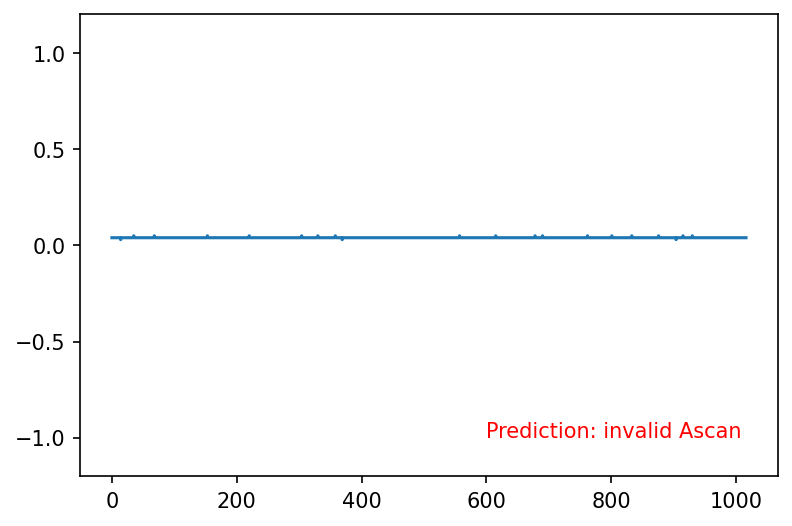

In [325]:
ret1_face1_utd1.plot_ascan(sensor=6, index=10, show_peaks=True, show_prediction=True, model='model.h5')

In [326]:
ret1_face1_utd1.plot_interactive_ascan()

interactive(children=(IntSlider(value=4, description='sensor', max=8, min=1), IntSlider(value=62, description=…

In [208]:
ret1_face1_utd1.data.head()

,1,2,3,4,5,6,7,8
0,"[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.05, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0..."
1,"[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0..."
2,"[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0..."
3,"[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.04, 0.05, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.04, 0.05, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.04, 0.04, 0.04, 0.04, 0.04, 0.05, 0.04, 0.0..."
4,"[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.04, 0.04, 0.04, 0.05, 0.04, 0.04, 0.04, 0.0..."


In [327]:
ret1_nom_utd1 = Ut8channels('dataset/RET-001/Nomenclatura/RET-001-Nomenclatura-001.utd') # coring (and/or bubble and/or crack)

In [328]:
ret1_nom_utd1.plot_interactive_ascan()

interactive(children=(IntSlider(value=4, description='sensor', max=8, min=1), IntSlider(value=98, description=…

In [329]:
ret10_face1_utd1 = Ut8channels('dataset/RET-010/Face1/RET-010-Face1-001.utd')

In [330]:
ret10_face1_utd1.plot_interactive_ascan()

interactive(children=(IntSlider(value=4, description='sensor', max=8, min=1), IntSlider(value=62, description=…

In [331]:
ret12_face1_utd1 = Ut8channels('dataset/RET-012/Face1/RET-012-Face1-001.utd')

In [332]:
ret12_face1_utd1.plot_interactive_ascan() # recrystallization

interactive(children=(IntSlider(value=4, description='sensor', max=8, min=1), IntSlider(value=65, description=…

- iterate over folders
- read each file -> UT8channels
    - get data of sensor 6
    - filter out ascans that don't have peaks
    - append to list [filename, sensor, index, ascan, label]
- convert list of lists to dataframe
- create model
- train model
- evaluate model

In [285]:
class Ut8channelsTrainer:
    VALID_SENSOR = 6
    LEFT_OFFSET = 100
    RIGHT_OFFSET = 400
    LABELS = {
        'RET-001': 1, # coring and/or bubble and/or crack
        'RET-002': 1, # coring and/or bubble and/or crack
        'RET-003': 1, # coring and/or bubble and/or crack
        'RET-010': 0, # no defect
        'RET-011': 2, # recrystallization
        'RET-012': 2, # recrystallization
    }
    DEFECTS = {
        -1: 'invalid Ascan',
        0: 'no defect',
        1: 'coring',
        2: 'recrystallization'
    }

    def __init__(self, dataset_dir):
        self.dataset_dir = dataset_dir

    def read_process_and_annotate_each_ascan(self, cut_ascan=True):
        dataset = []
        for root, dirs, files in os.walk(self.dataset_dir):
            for file in files:
                if file.endswith('utd'): # if it is a valid ascan 
                    filename = os.path.join(root, file)
                    ut = Ut8channels(filename)
                    valid_ascans = ut.data[Ut8channelsTrainer.VALID_SENSOR] # get only data of sensor 6
                    for index, ascan in enumerate(valid_ascans): # get only ascans that had at least one peak detected
                        peaks = ut.find_relevant_peaks(ascan)
                        if len(peaks) >= 2: # expected at least 2 peaks: one for water, and another for the material
                            if cut_ascan:
                                left_threshold = max(0, peaks[1] - Ut8channelsTrainer.LEFT_OFFSET) # to not allow negative values
                                right_threshold = min(len(ascan), peaks[1] + Ut8channelsTrainer.RIGHT_OFFSET) # to not allow values > len(ascan)
                                ascan = ascan[left_threshold:right_threshold] 
                            label = Ut8channelsTrainer.LABELS[file[0:7]] # to get the corresponding value for 'RET-xxx'
                            dataset.append([file, Ut8channelsTrainer.VALID_SENSOR, index, ascan, label])                            
        dataset = pd.DataFrame(dataset)
        dataset.columns = ['file', 'sensor', 'index', 'ascan', 'label']
        return dataset     

    def split_data(self, dataset, val_size=0.2, test_size=0.2, print_size=True):
        X = dataset['ascan']
        # X = dataset[['ascan']].values # doesn't work
        y = dataset['label']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=val_size, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_size, random_state=42)
        X_train = tf.convert_to_tensor(list(X_train), dtype=np.float32)
        X_val = tf.convert_to_tensor(list(X_val), dtype=np.float32)
        X_test = tf.convert_to_tensor(list(X_test), dtype=np.float32)
        if print_size:
            print('X_train', X_train.shape)
            print('y_train', y_train.shape)
            print('X_val', X_val.shape)
            print('y_val', y_val.shape)
            print('X_test', X_test.shape)
            print('y_test', y_test.shape)
        return X_train, y_train, X_val, y_val, X_test, y_test

    ########################## NEURAL NETWORK MODEL ##########################

    def create_model(self, print_summary=True):    
        input_size = Ut8channelsTrainer.LEFT_OFFSET + Ut8channelsTrainer.RIGHT_OFFSET

        model = keras.models.Sequential([
            keras.layers.Dense(32, input_shape=(input_size,), activation='relu'),
            keras.layers.Dense(len(set(Ut8channelsTrainer.LABELS.values())), activation="softmax")
        ])

        model.compile(
            loss='sparse_categorical_crossentropy', # with softmax (e.g. 0, or 1, or 2, or 3, or 4...)
            # loss="binary_crossentropy", # with sigmoid (e.g. 0 or 1)
            optimizer="adam", # rmsprop
            metrics=["accuracy"]
        )
        if print_summary:
            model.summary()

        return model
 
    def train_model(self, model, X_train, y_train, X_val, y_val, X_test, y_test, epochs, *, name=None):
        run_logdir = self.get_run_logdir(name)
        tensorboard_cb = keras.callbacks.TensorBoard(run_logdir) # create event files within run_logdir    
        history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), callbacks=[tensorboard_cb])
        y_prob = model.predict(X_test)
        y_pred = y_prob.argmax(axis=-1)
        accuracy = accuracy_score(y_test, y_pred)
        print('accuracy = {}'.format(accuracy)) 

    def evaluate_model(self, model, X_test, y_test, save_confusion_matrix=False):
        y_prob = model.predict(X_test) # probabilities
        y_pred = y_prob.argmax(axis=-1) # predictions
        # accuracy = model.evaluate(X_test, y_test)[1] # [loss, accuracy]
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        print('Accuracy on test set: {}'.format(accuracy))
        print('Average F1 score: {}'.format(f1))        
        disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical', cmap='Blues', colorbar=False)
        plt.suptitle('Confusion Matrix - {}'.format(model))
        plt.grid(False)   
        if save_confusion_matrix:
            plt.savefig("confusion-matrix.png", dpi=300)
        plt.show()

    def save_model(self, model, name='model'):
        name += '.h5'
        model.save(name)

    def load_model(self, model):
        return keras.models.load_model(model)

    ########################## AUXILIARY METHODS ##########################

    @staticmethod
    def get_run_logdir(name=None):    
        root_logdir = os.path.join(os.curdir, "logs")
        run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S") if name is None else name
        return os.path.join(root_logdir, run_id)              


In [292]:
Ut8channelsTrainer.DEFECTS[prediction[0]]

'coring'

In [121]:
data = Ut8channelsTrainer('dataset/')
dataset = data.read_process_and_annotate_each_ascan()

In [122]:
dataset.head()

,file,sensor,index,ascan,label
0,RET-003-Nomenclatura-003.utd,6,18,"[-1.0, -1.0, -1.0, -1.0, -1.0, -0.97, -0.78, -...",1
1,RET-003-Nomenclatura-003.utd,6,19,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",1
2,RET-003-Nomenclatura-003.utd,6,20,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",1
3,RET-003-Nomenclatura-003.utd,6,21,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",1
4,RET-003-Nomenclatura-003.utd,6,22,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",1


In [123]:
dataset.shape

(6321, 5)

In [237]:
frase = 'Coring'

Text(0.5, 5, 'This is a Coring')

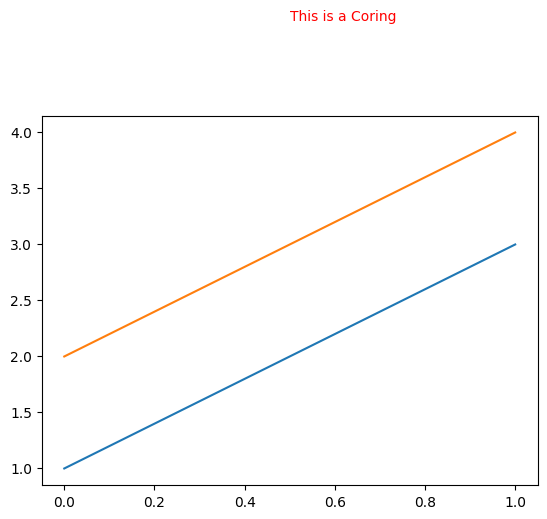

In [238]:
plt.plot([[1,2], [3,4]])
plt.text(0.5, 5, f'This is a {frase}', color='r')

In [142]:
# dataset.to_csv('dataset.csv')

### Visualizing samples of each class

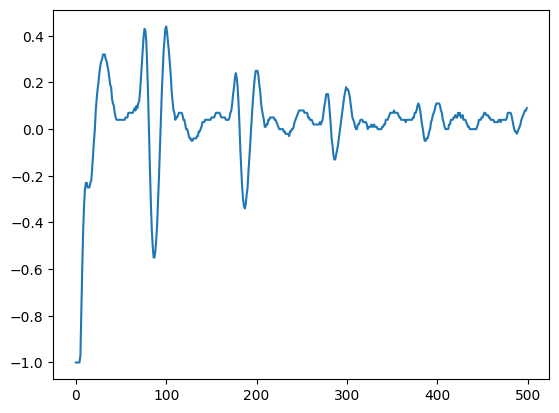

In [143]:
plt.plot(dataset['ascan'][0]) # coring

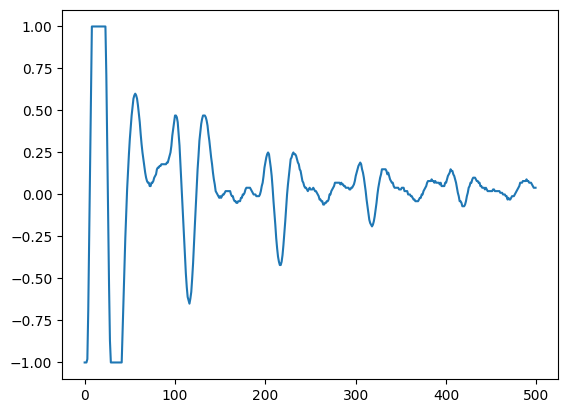

In [144]:
plt.plot(dataset['ascan'][6316]) # no defect

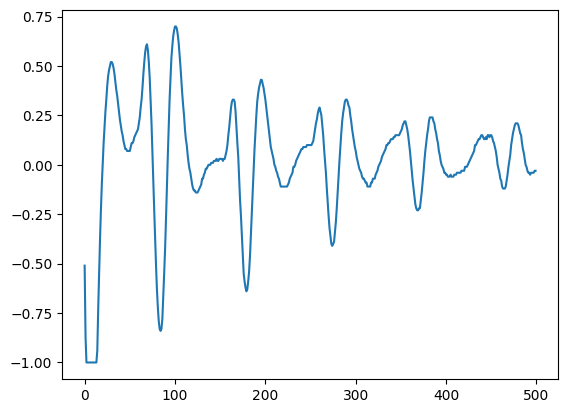

In [145]:
plt.plot(dataset['ascan'][3569]) # recrystallization

### Training NN

In [146]:
dataset['ascan']

0       [-1.0, -1.0, -1.0, -1.0, -1.0, -0.97, -0.78, -...
1       [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....
2       [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....
3       [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....
4       [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....
                              ...                        
6316    [-1.0, -1.0, -1.0, -0.98, -0.69, -0.27, 0.17, ...
6317    [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....
6318    [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0....
6319    [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....
6320    [-1.0, -1.0, -1.0, -1.0, -1.0, -0.97, -0.77, -...
Name: ascan, Length: 6321, dtype: object

In [147]:
print(type(dataset['ascan']))
print(type(dataset['ascan'][0]))
print(type(dataset['ascan'][0][0]))


<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'numpy.float64'>


In [126]:
X_train, y_train, X_val, y_val, X_test, y_test = data.split_data(dataset, print_size=True)

X_train (4044, 500)
y_train (4044,)
X_val (1012, 500)
y_val (1012,)
X_test (1265, 500)
y_test (1265,)


In [149]:
model = data.create_model()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 32)                16032     
                                                                 
 dense_17 (Dense)            (None, 3)                 99        
                                                                 
Total params: 16,131
Trainable params: 16,131
Non-trainable params: 0
_________________________________________________________________


In [150]:
data.train_model(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=100, name=None)

Epoch 1/100
127/127 [==============================] - 1s 2ms/step - loss: 0.4187 - accuracy: 0.8415 - val_loss: 0.2764 - val_accuracy: 0.9081
Epoch 2/100
127/127 [==============================] - 0s 1ms/step - loss: 0.2695 - accuracy: 0.8801 - val_loss: 0.2297 - val_accuracy: 0.9071
Epoch 3/100
127/127 [==============================] - 0s 1ms/step - loss: 0.2360 - accuracy: 0.8919 - val_loss: 0.2051 - val_accuracy: 0.9121
Epoch 4/100
127/127 [==============================] - 0s 1ms/step - loss: 0.2153 - accuracy: 0.8964 - val_loss: 0.1890 - val_accuracy: 0.9111
Epoch 5/100
127/127 [==============================] - 0s 1ms/step - loss: 0.1921 - accuracy: 0.9132 - val_loss: 0.1665 - val_accuracy: 0.9180
Epoch 6/100
127/127 [==============================] - 0s 1ms/step - loss: 0.1753 - accuracy: 0.9268 - val_loss: 0.1556 - val_accuracy: 0.9575
Epoch 7/100
127/127 [==============================] - 0s 1ms/step - loss: 0.1559 - accuracy: 0.9387 - val_loss: 0.1383 - val_accuracy: 0.9704

In [151]:
%reload_ext tensorboard
# %load_ext tensorboard
%tensorboard --logdir=./logs --port=8888

Reusing TensorBoard on port 8888 (pid 23269), started 0:50:34 ago. (Use '!kill 23269' to kill it.)

40/40 [==============================] - 0s 790us/step
Accuracy on test set: 0.9952569169960475
Average F1 score: 0.9920321574686007


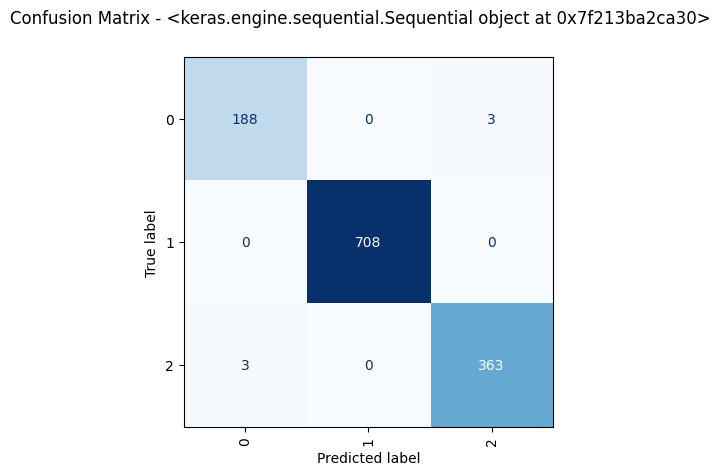

In [152]:
data.evaluate_model(model, X_test, y_test)

In [154]:
# data.save_model(model)

In [124]:
loaded_model = data.load_model('model.h5')

In [127]:
some_data_x = X_test[0:10]
some_data_y = y_test[0:10]

/tmp/ipykernel_7586/1192502718.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  some_data_y = y_test[0:10]


In [137]:
some_data_x[0:2]

<tf.Tensor: shape=(2, 500), dtype=float32, numpy=
array([[ 0.23,  0.22,  0.23,  0.22,  0.22,  0.21,  0.2 ,  0.2 ,  0.18,
         0.18,  0.18,  0.18,  0.17,  0.16,  0.16,  0.15,  0.15,  0.14,
         0.13,  0.12,  0.11,  0.11,  0.11,  0.1 ,  0.1 ,  0.08,  0.08,
         0.08,  0.07,  0.07,  0.07,  0.05,  0.05,  0.05,  0.05,  0.04,
         0.04,  0.04,  0.04,  0.05,  0.05,  0.05,  0.05,  0.05,  0.05,
         0.05,  0.06,  0.07,  0.06,  0.07,  0.06,  0.06,  0.05,  0.05,
         0.04,  0.04,  0.04,  0.03,  0.02,  0.02,  0.03,  0.04,  0.07,
         0.11,  0.16,  0.22,  0.27,  0.32,  0.35,  0.36,  0.35,  0.3 ,
         0.25,  0.16,  0.07, -0.04, -0.17, -0.29, -0.4 , -0.52, -0.62,
        -0.72, -0.78, -0.82, -0.83, -0.8 , -0.75, -0.65, -0.54, -0.4 ,
        -0.25, -0.11,  0.04,  0.17,  0.29,  0.38,  0.47,  0.53,  0.58,
         0.62,  0.62,  0.62,  0.61,  0.57,  0.52,  0.47,  0.4 ,  0.35,
         0.29,  0.22,  0.18,  0.12,  0.08,  0.04,  0.02, -0.  , -0.03,
        -0.04, -0.06, -0.07

In [135]:
type(some_data_x[0:1])

tensorflow.python.framework.ops.EagerTensor

In [134]:
loaded_model.predict(some_data_x[0:1]).argmax(axis=-1)

1/1 [==============================] - 0s 14ms/step


array([1])